# 0. Notes:

This notebook shows how to identify vessels transiting in Suez Canal. We apply the same procedures from the `Suez 0 Benchmarking.ipynb` notebook but for period during the blockage. 

Connect to the UN Global Platform and use kernel `pyspark3.5 ais2.9`

# 1. Initialize

In [1]:
import geopandas as gpd
from shapely.geometry import mapping, Polygon

from pyspark.sql import functions as F
from pyspark.sql import Window as W
from ais import functions as af
import h3.api.numpy_int as h3int

import matplotlib.pyplot as plt

generated new fontManager


In [2]:
from sedona.spark import *

sedona = SedonaContext.create(spark)

Skipping SedonaKepler import, verify if keplergl is installed
Skipping SedonaPyDeck import, verify if pydeck is installed


In [3]:
import requests
import base64
import os
import pandas as pd
from io import StringIO

In [4]:
passageway = "suez_canal"
raw_ais_save_path = os.environ["USER_TEMP_S3PATH"] + f"cherryl/ais_passageways/{passageway}/ais/"

# 2. Geometries

In [5]:
request = requests.get(f"https://api.github.com/repos/cherrylchico/ais_passageways/contents/data/{passageway}.geojson")
gdf = gpd.read_file(base64.b64decode(request.json()['content']).decode('utf-8'))
gdf

,Label,POI,geometry
0,North Anchorage,North,"POLYGON ((32.37009 31.32180, 32.57678 31.32166..."
1,Great Bitter Lake,Middle,"POLYGON ((32.28697 30.34816, 32.31222 30.28512..."
2,South Anchorage,South,"POLYGON ((32.52850 29.93424, 32.48518 29.92898..."


Input polygon is too small to be filled in with hexagon of resolution: 4
Attempting to fit a hex of resolution: 5...
A hex of resolution: 5 fits the input polygon
Finding it's parent in resolution: 4
Input polygon is too small to be filled in with hexagon of resolution: 4
Attempting to fit a hex of resolution: 5...
A hex of resolution: 5 fits the input polygon
Finding it's parent in resolution: 4

H3 count:19


<Axes: >

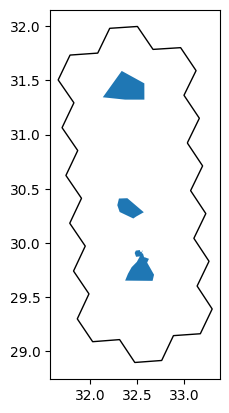

In [6]:
#We use H3 indices (https://h3geo.org/docs) as a geo-spatial filter for AIS data in the UNGP. 
#To get all AIS data within the AOIs, we overfill the geometries with H3 indices, then use the list of H3 indices as filter.  
#To ensure that the filtering is efficient, the number of H3 indices should small and the area outside of the AOI should also be small
#here, we chose H3 index resolution 4. 

h3_resolution = 4

inputs = [(row['POI'], mapping(row['geometry'])) for index, row in gdf.iterrows()]
hex_df = af.polygon_to_hex_df(inputs, h3_resolution, overfill=True)
hexes = hex_df['hex_id'].drop_duplicates().tolist()

print(f"\nH3 count:{len(hexes)}")
hexes = hex_df['hex_id'].drop_duplicates().tolist()
h3_gdf = gpd.GeoDataFrame([["H3",Polygon(h3int.h3_set_to_multi_polygon(hexes, geo_json=True)[0][0])]], columns=['h3','geometry'], crs=4326)
fig, ax = plt.subplots()
gdf.plot(ax=ax)
h3_gdf.plot(ax=ax, facecolor="none")

# 3. Extract AIS data and save to S3

## 3.1 Preparation

In [7]:
ais_cols = [
 'mmsi',
 'longitude',
 'latitude',
 'imo',
 'vessel_name',
 'vessel_type',
 'destination',
 'sog',
 'nav_status',
 'dt_pos_utc']

In [8]:
#Read Ship Register datasets as a spark dataframe, use version 20210609 which is the earliest version available in UNGP
#note that af module is from the ais package 

#The ShipData table provides information on the vessel's IMO, vessel type described by the StatCode5 and ShiptypeLevel5
ihs = af.read_ihs_table(spark, "ShipData.CSV", version="20210609") \
.select("ShipName","LRIMOShipNo","MaritimeMobileServiceIdentityMMSINumber","StatCode5","ShiptypeLevel5")

#We use the tblShipTypeCodes table to get more information on the vessel type.
#We select only "Cargo-carrying vessels" which is identified by ShiptypeLevel2 information
ihs_statcode = af.read_ihs_table(spark, "tblShipTypeCodes.CSV",  version="20210609") \
.select("StatCode5","ShiptypeLevel2") \
.filter(F.col("ShiptypeLevel2").isin(["Bulk Carriers", "Dry Cargo/Passenger", "Tankers"]))

In [9]:
#Convert geometries to spark dataframe to prepare for spark processing of geospatial data
sdf_poly = sedona.createDataFrame(gdf[['geometry','POI']])

In [10]:
def extract_passageway_cargo(start_date, end_date, hexes, raw_ais_save_path, mode="overwrite"):
    #Read AIS within the start date and end date where hex ids are within the hexes list
    sdf = af.get_ais(spark, start_date=start_date, end_date=end_date, h3_list = hexes)
    
    #Get only AIS where location is within the POI geometries
    sdf_w_point = sdf.withColumn("point", F.expr("ST_Point(longitude, latitude)"))
    sdf_w_point.createOrReplaceTempView("ais_temp")
    sdf_poly.createOrReplaceTempView("poly_temp")
    sdf_poly_filter = spark.sql(""" select  * from ais_temp, poly_temp where ST_Within(point, geometry)""")
    
    #Get only AIS where the type is cargo related
    sdf_cargo = sdf_poly_filter.join(ihs.withColumnRenamed("LRIMOShipNo","imo"), how="inner", on=['imo']) \
    .join(ihs_statcode, how="inner", on=['StatCode5']) \
    .select(*ais_cols, "ShipName","MaritimeMobileServiceIdentityMMSINumber","StatCode5","ShiptypeLevel5","ShiptypeLevel2","POI") \
    .withColumns({"year":F.year("dt_pos_utc"),"month":F.month("dt_pos_utc")})
    
    #Save in S3
    sdf_cargo.write.mode(mode).partitionBy("year","month").parquet(raw_ais_save_path)
    return sdf_cargo

## 3.2 Run

In [13]:
#Run the extraction process per month. Note that we are "appending" the data
#to not overwrite the data from the Benchmarking Notebook.
start_date = "2021-03-01"
end_date = "2021-03-31"
sdf = extract_passageway_cargo(start_date, end_date, hexes, raw_ais_save_path, mode="append")

In [14]:
start_date = "2021-04-01"
end_date = "2021-04-30"
sdf = extract_passageway_cargo(start_date, end_date, hexes, raw_ais_save_path, mode="append")

# 4. Get transits

## 4.1 Preparation

In [5]:
w = W.partitionBy("imo").orderBy("dt_pos_utc")
def get_transits(sdf, min_time_diff):
    #This function identifies the "voyages" of a vessel
    #The voyage groups together consecutive messages that likely came from a single transit through the Suez canal
    #A message is identified to have come from a different voyage is the time between the messages is at least a defined time period
    sdf_groups = sdf.withColumn("prev_dt_pos_utc", F.lag("dt_pos_utc").over(w)) \
    .withColumn("time_diff_hours", (F.col("dt_pos_utc").cast("long") - F.col("prev_dt_pos_utc").cast("long")) / 3600) \
    .withColumn("time_diff_flag", F.when(F.col("time_diff_hours").isNull(), 1) \
                                    .when(F.col("time_diff_hours") > min_time_diff,1) \
                                    .otherwise(0)) \
    .withColumn("voyage", F.sum("time_diff_flag").over(w)) \
    .withColumn("idle_hours", F.when(F.col("sog") < 1, F.col("time_diff_hours")).otherwise(0))
    
    #get important information from the voyages needed to identify transits and produce statistics
    transits_sdf = sdf_groups \
    .groupBy("imo","voyage") \
    .agg(F.first("vessel_name").alias("vessel_name"),
         F.first("StatCode5").alias("StatCode5"),
         F.first("ShiptypeLevel2").alias("ShiptypeLevel2"),
         F.first("ShiptypeLevel5").alias("ShiptypeLevel5"),
         F.min("dt_pos_utc").alias("arrival_date"),
         F.max("dt_pos_utc").alias("departure_date"),
         F.min_by("POI", "dt_pos_utc").alias("arrival_POI"),
         F.max_by("POI", "dt_pos_utc").alias("departure_POI"),
         F.countDistinct("POI").alias("count_distinct_POI"),
         F.sum("idle_hours").alias("idle_time")
        ) \
    .filter(F.col("arrival_POI")!=F.col("departure_POI")) \
    .withColumn("dwell_time",  (F.col("departure_date").cast("long") - F.col("arrival_date").cast("long")) / 3600) \
    .withColumn("direction",     F.concat(F.col("arrival_POI"), F.lit("-"), F.col("departure_POI"))) \
    .withColumn("complete_transit_flag", F.col("direction").isin(['North-South','South-North'])) 
    
    return transits_sdf

## 4.2 Run

In [6]:
#Read the extracted data from Section 3
sdf = spark.read.parquet(raw_ais_save_path + "year=2021/month=3/",
                         raw_ais_save_path + "year=2021/month=4/")
print(f"Total AIS messages: {sdf.count():,}")
sdf.show(n=1, truncate=False, vertical =True)

Total AIS messages: 831,071
-RECORD 0---------------------------------------------------------
 mmsi                                    | 671659000              
 longitude                               | 32.567233333333334     
 latitude                                | 29.65784               
 imo                                     | 7041053                
 vessel_name                             | PACIFIC M              
 vessel_type                             | Cargo                  
 destination                             | EG SUZ                 
 sog                                     | 6.6                    
 nav_status                              | Under Way Using Engine 
 dt_pos_utc                              | 2021-04-18 05:38:03    
 ShipName                                | PACIFIC M              
 MaritimeMobileServiceIdentityMMSINumber | 671659000              
 StatCode5                               | A38A2GL                
 ShiptypeLevel5                   

In [7]:
#Identify transits, using minimum time input of 16 hrs. 
transits_df =  get_transits(sdf, 16).toPandas()
transits_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3059 entries, 0 to 3058
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   imo                    3059 non-null   int32         
 1   voyage                 3059 non-null   int64         
 2   vessel_name            3059 non-null   object        
 3   StatCode5              3059 non-null   object        
 4   ShiptypeLevel2         3059 non-null   object        
 5   ShiptypeLevel5         3059 non-null   object        
 6   arrival_date           3059 non-null   datetime64[ns]
 7   departure_date         3059 non-null   datetime64[ns]
 8   arrival_POI            3059 non-null   object        
 9   departure_POI          3059 non-null   object        
 10  count_distinct_POI     3059 non-null   int64         
 11  idle_time              3059 non-null   float64       
 12  dwell_time             3059 non-null   float64       
 13  dir

In [8]:
#Each row of the output is a vessel transit. 
transits_df.head()

,imo,voyage,vessel_name,StatCode5,ShiptypeLevel2,ShiptypeLevel5,arrival_date,departure_date,arrival_POI,departure_POI,count_distinct_POI,idle_time,dwell_time,direction,complete_transit_flag
0,7104972,1,FREEDOM,A38A2GL,Dry Cargo/Passenger,Livestock Carrier,2021-03-21 18:54:55,2021-03-22 18:53:01,North,South,3,9.056111,23.968333,North-South,True
1,7104972,3,FREEDOM,A38A2GL,Dry Cargo/Passenger,Livestock Carrier,2021-04-03 11:42:56,2021-04-04 05:22:27,Middle,North,2,6.957500,17.658611,Middle-North,False
2,7113624,3,MARIONA,A38A2GL,Dry Cargo/Passenger,Livestock Carrier,2021-03-19 05:17:48,2021-03-20 20:06:23,South,North,3,4.795000,38.809722,South-North,True
3,7113624,5,MARIONA,A38A2GL,Dry Cargo/Passenger,Livestock Carrier,2021-04-09 17:06:30,2021-04-10 04:13:05,Middle,South,2,0.122778,11.109722,Middle-South,False
4,7113624,7,MARIONA,A38A2GL,Dry Cargo/Passenger,Livestock Carrier,2021-04-19 07:27:14,2021-04-19 19:27:40,South,North,3,0.000000,12.007222,South-North,True


## 4.3 Attach SCA categories

In [9]:
#Read the vessel type mapping between IHS and SCA vessel types. Note that the mapping was done by the authors based on available information from the two sources
request = requests.get(f"https://api.github.com/repos/cherrylchico/ais_passageways/contents/data/IHS SCA Vessel Category Mapping.csv")
mapping = pd.read_csv(StringIO(base64.b64decode(request.json()['content']).decode('utf-8')))
mapping.head()

,StatCode5,ShiptypeLevel2,ShiptypeLevel5,SCA Vessel Type
0,A11A2TN,Tankers,LNG Tanker,LNG Ships
1,A11A2TZ,Tankers,Combination Gas Tanker (LNG/LPG),LNG Ships
2,A11B2TG,Tankers,LPG Tanker,Tankers
3,A11B2TH,Tankers,LPG/Chemical Tanker,Tankers
4,A12A2LP,Tankers,Molten Sulphur Tanker,Tankers


In [10]:
#Determine SCA vessel type to vessel transits
transits_df["SCA_Vessel_Type"] = transits_df['StatCode5'].map(mapping.set_index("StatCode5")["SCA Vessel Type"])

# 5. Statistics

## 5.1 Count of Transit

In [11]:
n = transits_df[~transits_df['complete_transit_flag'] ].shape[0] / transits_df.shape[0]
print(f"""
Total Transits: {transits_df.shape[0]:,}
Complete Transits: {transits_df['complete_transit_flag'].sum():,}
Additional Transits due to Redundancy: {n*100:.2f}%
""")


Total Transits: 3,059
Complete Transits: 2,783
Additional Transits due to Redundancy: 9.02%



In [12]:
count_per_poi = transits_df.groupby(["ShiptypeLevel2", "SCA_Vessel_Type"]) \
.agg({'complete_transit_flag':'sum', 'imo':'count'}) \
.rename(columns={'complete_transit_flag':'North/South', 'imo':'North/South/Middle'})
count_per_poi['% increase'] = 100*((count_per_poi['North/South/Middle'] - count_per_poi['North/South']) / count_per_poi['North/South'])
count_per_poi

#Count of Transits According to Vessel Type and POIs captured
#Note: North/South means that the start and end POIs are both in either North or South. Thus it also contains those that passed Middle
#North/South/Middle has Middle as either start or end POIs. 

North/South  North/South/Middle  \
ShiptypeLevel2      SCA_Vessel_Type                                    
Bulk Carriers       Bulk Carrier             780                 827   
Dry Cargo/Passenger Car Carrier              141                 148   
                    Container Ships          707                 809   
                    General Cargo            283                 346   
                    Passenger Ships            2                   2   
                    RoRo                      24                  26   
Tankers             LNG Ships                134                 134   
                    Tankers                  708                 763   

                                     % increase  
ShiptypeLevel2      SCA_Vessel_Type              
Bulk Carriers       Bulk Carrier       6.025641  
Dry Cargo/Passenger Car Carrier        4.964539  
                    Container Ships   14.427157  
                    General Cargo     22.261484  
                    Passenger Ships    0.000000  
                    RoRo               8.333333  
Tankers             LNG Ships          0.000000  
                    Tankers            7.768362

In [13]:
af.create_download_link(count_per_poi, "Suez Canal Transits per Type and POI 202103-202104 using AIS.csv", "Suez Canal Transits per Type and POI 202103-202104 using AIS.csv")

## 5.2 Daily Count

In [14]:
transits_stats = transits_df \
.groupby(pd.Grouper(key="arrival_date", freq="D")) \
.agg({'imo':'count'}) \
.rename(columns={'imo':'transit_per_arrival_day'}) \
.join(transits_df[transits_df['complete_transit_flag']] \
      .groupby(pd.Grouper(key="arrival_date", freq="D")) \
      .agg({'imo':'count',
            'dwell_time':'median',
            'idle_time':'median'}) \
     .rename(columns={'imo':'complete_transit_per_arrival_day',
                      'dwell_time':'complete_transit_dwell_time',
                      'idle_time':'complete_transit_idle_time'})
     )

In [15]:
transits_stats.iloc[1:-1]

,transit_per_arrival_day,complete_transit_per_arrival_day,complete_transit_dwell_time,complete_transit_idle_time
arrival_date,,,,
2021-03-02,49,44,29.300417,13.614444
2021-03-03,56,52,27.065139,11.646528
2021-03-04,53,49,28.229722,11.860833
2021-03-05,46,41,27.991389,12.349167
2021-03-06,59,53,26.499722,11.432222
2021-03-07,56,53,25.796111,11.855000
2021-03-08,60,55,26.239722,10.325556
2021-03-09,60,56,27.542500,12.671389
2021-03-10,55,51,25.819167,10.422222


In [16]:
#To get the outputs for  local storage
af.create_download_link(transits_stats, "Suez Canal Daily Transits 202103-202104 using AIS.csv","Suez Canal Daily Transits 202103-202104 using AIS.csv")

## 5.3 Queued vessels

In [35]:
preblockage = (transits_stats.index <= "2021-03-21") & (transits_stats.index >= "2021-03-02")
blockage = (transits_stats.index >= "2021-03-22") & (transits_stats.index <= "2021-03-29")
recovery = (transits_stats.index >= "2021-03-30") & (transits_stats.index <= "2021-04-08")
postrecovery = (transits_stats.index >= "2021-04-09")   & (transits_stats.index <= "2021-04-29")

In [36]:
#excluding start and end dates

print(f"""
Pre-Incident BAU stats:
{transits_stats[preblockage].mean().round()}

Blockage stats:
{transits_stats[blockage].mean().round()}

Recovery stats:
{transits_stats[recovery].mean().round()}

Port-Indicent BAU stats:
{transits_stats[postrecovery].mean().round()}
""")


Pre-Incident BAU stats:
transit_per_arrival_day             52.0
complete_transit_per_arrival_day    49.0
complete_transit_dwell_time         27.0
complete_transit_idle_time          12.0
dtype: float64

Blockage stats:
transit_per_arrival_day              32.0
complete_transit_per_arrival_day     26.0
complete_transit_dwell_time         150.0
complete_transit_idle_time          134.0
dtype: float64

Recovery stats:
transit_per_arrival_day             61.0
complete_transit_per_arrival_day    56.0
complete_transit_dwell_time         61.0
complete_transit_idle_time          46.0
dtype: float64

Port-Indicent BAU stats:
transit_per_arrival_day             49.0
complete_transit_per_arrival_day    45.0
complete_transit_dwell_time         26.0
complete_transit_idle_time          11.0
dtype: float64



In [39]:
preblockage = (transits_df.arrival_date <= "2021-03-21") & (transits_df.arrival_date >= "2021-03-02")
blockage = (transits_df.arrival_date >= "2021-03-22") & (transits_df.arrival_date <= "2021-03-29")
recovery = (transits_df.arrival_date >= "2021-03-30") & (transits_df.arrival_date <= "2021-04-08")
postrecovery = (transits_df.arrival_date >= "2021-04-09")   & (transits_df.arrival_date <= "2021-04-29")

In [40]:
print(f"BAU Dwell Time Distribution (Complete Transits Only)")
transits_df[(preblockage | postrecovery) & transits_df['complete_transit_flag']].dwell_time.describe(percentiles=[0.5,0.6, 0.7,0.8,0.9,0.95,0.99])

BAU Dwell Time Distribution (Complete Transits Only)


count    1840.000000
mean       30.404616
std        27.880433
min        10.741944
50%        26.444306
60%        28.790278
70%        31.326917
80%        34.848222
90%        39.150306
95%        45.419514
99%        98.900092
max       678.595000
Name: dwell_time, dtype: float64

In [42]:
max_dwell_time_bau = transits_df[(preblockage | postrecovery) & transits_df['complete_transit_flag']].dwell_time.quantile(0.95)
n =  transits_df[(recovery | blockage) & transits_df['complete_transit_flag']].shape[0]
queued =  transits_df[(recovery | blockage) & transits_df['complete_transit_flag'] & (transits_df['dwell_time'] >= max_dwell_time_bau)].shape[0]
print(f"""
Total Transits Blockage + Recovery: {n}
Max Dwell Time During BAU: {max_dwell_time_bau:.0f} hours
Affected vessels (queued): {queued}
% Vessels Affected: {(queued / n )*100: .2f}%

Note that figures only include vessels with complete transits
""")


Total Transits Blockage + Recovery: 690
Max Dwell Time During BAU: 45 hours
Affected vessels (queued): 507
% Vessels Affected:  73.48%

Note that figures only include vessels with complete transits

